## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp025'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext101_32x4d'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [ #https://www.kaggle.com/competitions/hubmap-kidney-segmentation/discussion/238013
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9,
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.ElasticTransform(p=.3),
            A.GaussianBlur(p=.3),
            A.GaussNoise(p=.3),
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.3),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3,p=0.3),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:299: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list,p=1.0)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list,p=1.0)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

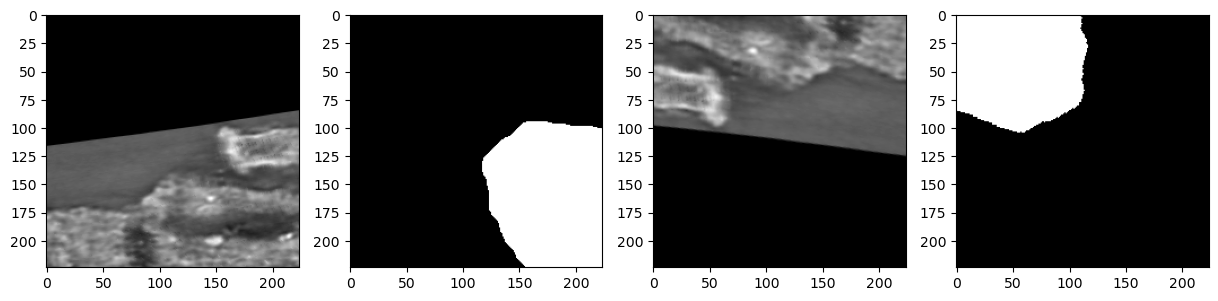

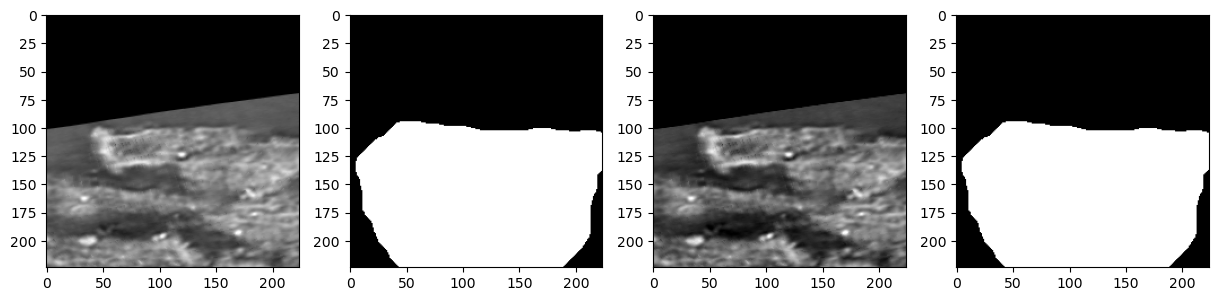

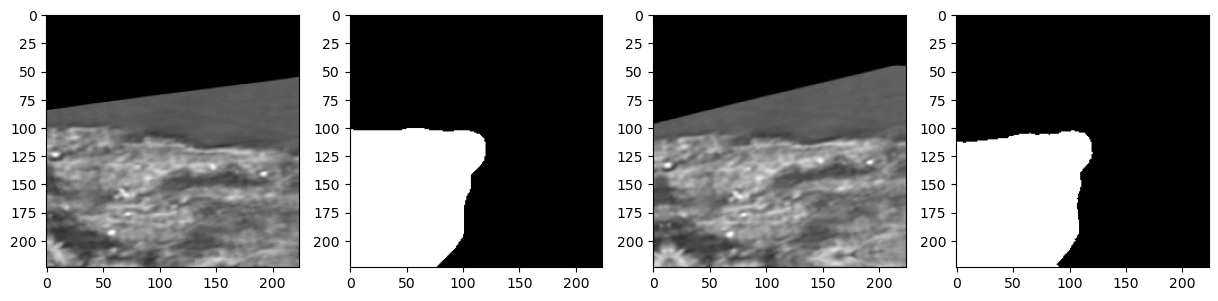

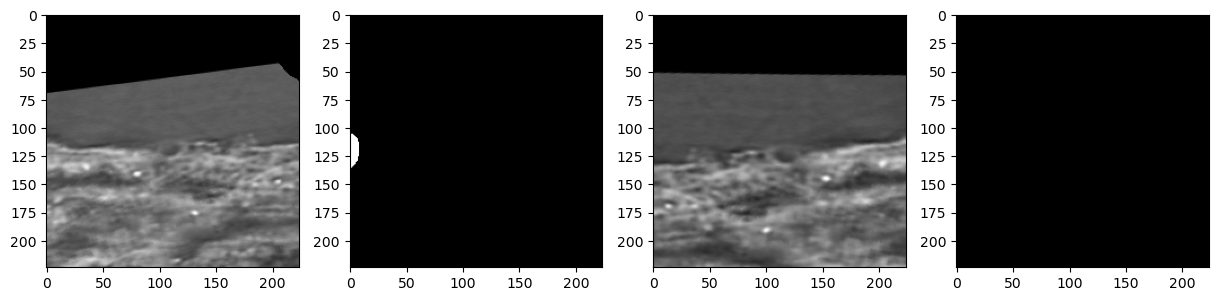

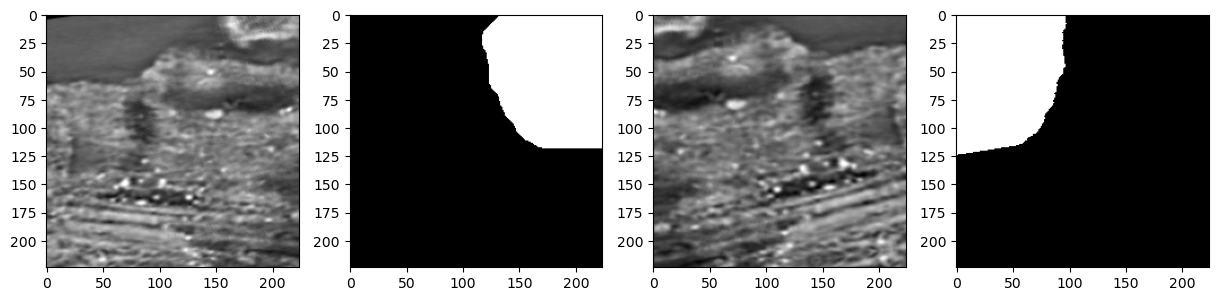

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48105

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09501435755593886
th: 0.15, fbeta: 0.0950456236535603
th: 0.2, fbeta: 0.13073794984398066
th: 0.25, fbeta: 0.15740013745189949
th: 0.3, fbeta: 0.21100711623954255
th: 0.35, fbeta: 0.29313750964887475
th: 0.4, fbeta: 0.3581492913985427


best_th: 0.5, fbeta: 0.4137475223817122
Epoch 1 - avg_train_loss: 0.5666  avg_val_loss: 0.3808  time: 162s
Epoch 1 - avgScore: 0.4137
Epoch 1 - Save Best Score: 0.4137 Model
Epoch 1 - Save Best Loss: 0.3808 Model


th: 0.45, fbeta: 0.39584679368628256
th: 0.5, fbeta: 0.4137475223817122


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09503970906972734
th: 0.15, fbeta: 0.14573453187181537
th: 0.2, fbeta: 0.1839126711599636
th: 0.25, fbeta: 0.3016508027003079
th: 0.3, fbeta: 0.36711495456482574
th: 0.35, fbeta: 0.4094645852228917
th: 0.4, fbeta: 0.4427631773547433
th: 0.45, fbeta: 0.46417361006490193


best_th: 0.5, fbeta: 0.4830238311234244
Epoch 2 - avg_train_loss: 0.3822  avg_val_loss: 0.3009  time: 164s
Epoch 2 - avgScore: 0.4830
Epoch 2 - Save Best Score: 0.4830 Model
Epoch 2 - Save Best Loss: 0.3009 Model


th: 0.5, fbeta: 0.4830238311234244


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.3150477209885836
th: 0.15, fbeta: 0.40040395402892864
th: 0.2, fbeta: 0.45519930424728644
th: 0.25, fbeta: 0.495555944477754
th: 0.3, fbeta: 0.5220382147672915
th: 0.35, fbeta: 0.5407433561963788
th: 0.4, fbeta: 0.5517735751997571
th: 0.45, fbeta: 0.5430883169796639


best_th: 0.4, fbeta: 0.5517735751997571
Epoch 3 - avg_train_loss: 0.2897  avg_val_loss: 0.1914  time: 161s
Epoch 3 - avgScore: 0.5518
Epoch 3 - Save Best Score: 0.5518 Model
Epoch 3 - Save Best Loss: 0.1914 Model


th: 0.5, fbeta: 0.5247216259577182


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2710828954339827
th: 0.15, fbeta: 0.3281638364404393
th: 0.2, fbeta: 0.3792889834335922
th: 0.25, fbeta: 0.4195032241295768
th: 0.3, fbeta: 0.45358879864312107
th: 0.35, fbeta: 0.4823570843966557
th: 0.4, fbeta: 0.5080536871561724
th: 0.45, fbeta: 0.5322029781353267


best_th: 0.5, fbeta: 0.5525020053211948
Epoch 4 - avg_train_loss: 0.2542  avg_val_loss: 0.1990  time: 162s
Epoch 4 - avgScore: 0.5525
Epoch 4 - Save Best Score: 0.5525 Model
Epoch 4 - Save Best Loss: 0.1990 Model


th: 0.5, fbeta: 0.5525020053211948


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.29323184182535933
th: 0.15, fbeta: 0.35221591202971453
th: 0.2, fbeta: 0.40396794458436214
th: 0.25, fbeta: 0.44630791440269174
th: 0.3, fbeta: 0.4844150771414103
th: 0.35, fbeta: 0.5244805899327508
th: 0.4, fbeta: 0.55923692972472


best_th: 0.5, fbeta: 0.594774742527931
Epoch 5 - avg_train_loss: 0.2378  avg_val_loss: 0.1812  time: 161s
Epoch 5 - avgScore: 0.5948
Epoch 5 - Save Best Score: 0.5948 Model
Epoch 5 - Save Best Loss: 0.1812 Model


th: 0.45, fbeta: 0.583765988258999
th: 0.5, fbeta: 0.594774742527931


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.260432357426301
th: 0.15, fbeta: 0.31484044567869296
th: 0.2, fbeta: 0.3689045311806612
th: 0.25, fbeta: 0.4218801023962826
th: 0.3, fbeta: 0.47050110578333826
th: 0.35, fbeta: 0.5079821466121063
th: 0.4, fbeta: 0.5328781263449128
th: 0.45, fbeta: 0.5498494678450562


best_th: 0.5, fbeta: 0.5599442830099859
Epoch 6 - avg_train_loss: 0.2284  avg_val_loss: 0.1995  time: 162s
Epoch 6 - avgScore: 0.5599


th: 0.5, fbeta: 0.5599442830099859


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30408235866749567
th: 0.15, fbeta: 0.36809584162094794
th: 0.2, fbeta: 0.42313109807301463
th: 0.25, fbeta: 0.46980547369357
th: 0.3, fbeta: 0.5086138013568539
th: 0.35, fbeta: 0.5388987671078126
th: 0.4, fbeta: 0.5572294457524277
th: 0.45, fbeta: 0.5727688613061375


best_th: 0.5, fbeta: 0.5832799415678661
Epoch 7 - avg_train_loss: 0.2163  avg_val_loss: 0.1924  time: 161s
Epoch 7 - avgScore: 0.5833


th: 0.5, fbeta: 0.5832799415678661


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31715187260447003
th: 0.15, fbeta: 0.3866274035451246
th: 0.2, fbeta: 0.44257878041473203
th: 0.25, fbeta: 0.48562210196567385
th: 0.3, fbeta: 0.5150213431645901
th: 0.35, fbeta: 0.5385044132177877
th: 0.4, fbeta: 0.5564582692066418
th: 0.45, fbeta: 0.5686323368183723


best_th: 0.5, fbeta: 0.5748459534326577
Epoch 8 - avg_train_loss: 0.2051  avg_val_loss: 0.1933  time: 161s
Epoch 8 - avgScore: 0.5748


th: 0.5, fbeta: 0.5748459534326577


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30463929630615344
th: 0.15, fbeta: 0.3595162154629326
th: 0.2, fbeta: 0.41196245754191607
th: 0.25, fbeta: 0.4556988339383164
th: 0.3, fbeta: 0.4934621073156684
th: 0.35, fbeta: 0.5237607405914471
th: 0.4, fbeta: 0.5496649846572882
th: 0.45, fbeta: 0.5717389266906853


best_th: 0.5, fbeta: 0.5910331319075887
Epoch 9 - avg_train_loss: 0.1945  avg_val_loss: 0.1907  time: 161s
Epoch 9 - avgScore: 0.5910


th: 0.5, fbeta: 0.5910331319075887


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39738712195562675
th: 0.15, fbeta: 0.4719158377777119
th: 0.2, fbeta: 0.5140808728810677
th: 0.25, fbeta: 0.5427243960172738
th: 0.3, fbeta: 0.5608356275598274
th: 0.35, fbeta: 0.5608453285658659
th: 0.4, fbeta: 0.5553452647317034
th: 0.45, fbeta: 0.5451742071286901


best_th: 0.35, fbeta: 0.5608453285658659
Epoch 10 - avg_train_loss: 0.1812  avg_val_loss: 0.1984  time: 166s
Epoch 10 - avgScore: 0.5608


th: 0.5, fbeta: 0.5256498636955325


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33177408329714997
th: 0.15, fbeta: 0.39068658703206155
th: 0.2, fbeta: 0.43449876345011224
th: 0.25, fbeta: 0.4724026228948916
th: 0.3, fbeta: 0.497838230455504
th: 0.35, fbeta: 0.518702136382375
th: 0.4, fbeta: 0.5377904883959979
th: 0.45, fbeta: 0.5457767402965846


best_th: 0.45, fbeta: 0.5457767402965846
Epoch 11 - avg_train_loss: 0.1714  avg_val_loss: 0.1940  time: 161s
Epoch 11 - avgScore: 0.5458


th: 0.5, fbeta: 0.5453850473054541


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3682847093730639
th: 0.15, fbeta: 0.42093994868937296
th: 0.2, fbeta: 0.4615919657054587
th: 0.25, fbeta: 0.49728269857338875
th: 0.3, fbeta: 0.5218632678109986
th: 0.35, fbeta: 0.5383416865884939
th: 0.4, fbeta: 0.5504424690939476
th: 0.45, fbeta: 0.5578138599970434


best_th: 0.5, fbeta: 0.5626470003785287
Epoch 12 - avg_train_loss: 0.1615  avg_val_loss: 0.1941  time: 160s
Epoch 12 - avgScore: 0.5626


th: 0.5, fbeta: 0.5626470003785287


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3241558456422906
th: 0.15, fbeta: 0.37268193476493205
th: 0.2, fbeta: 0.4166195024663996
th: 0.25, fbeta: 0.4541163419284679
th: 0.3, fbeta: 0.4848438948582064
th: 0.35, fbeta: 0.5108558856927057
th: 0.4, fbeta: 0.5334880120405996
th: 0.45, fbeta: 0.5544030566225061


best_th: 0.5, fbeta: 0.5674526731841869
Epoch 13 - avg_train_loss: 0.1533  avg_val_loss: 0.2013  time: 160s
Epoch 13 - avgScore: 0.5675


th: 0.5, fbeta: 0.5674526731841869


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3392595670374261
th: 0.15, fbeta: 0.37701541842219144
th: 0.2, fbeta: 0.40542807728984903
th: 0.25, fbeta: 0.432310135967375
th: 0.3, fbeta: 0.4575753432017464
th: 0.35, fbeta: 0.4816347810080963
th: 0.4, fbeta: 0.5028789876957533
th: 0.45, fbeta: 0.521123284852926


best_th: 0.5, fbeta: 0.5361960795527507
Epoch 14 - avg_train_loss: 0.1450  avg_val_loss: 0.2174  time: 160s
Epoch 14 - avgScore: 0.5362


th: 0.5, fbeta: 0.5361960795527507


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3183794855891922
th: 0.15, fbeta: 0.3628485452022646
th: 0.2, fbeta: 0.3976871397509465
th: 0.25, fbeta: 0.43013215283665035
th: 0.3, fbeta: 0.458181093930651
th: 0.35, fbeta: 0.48268787072739405
th: 0.4, fbeta: 0.5042944208891641


best_th: 0.5, fbeta: 0.5410144074605177
Epoch 15 - avg_train_loss: 0.1356  avg_val_loss: 0.2141  time: 160s
Epoch 15 - avgScore: 0.5410


th: 0.45, fbeta: 0.5238406781103213
th: 0.5, fbeta: 0.5410144074605177


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3461808469653967
th: 0.15, fbeta: 0.3842298428669972
th: 0.2, fbeta: 0.4114475944086108
th: 0.25, fbeta: 0.4359610155823805
th: 0.3, fbeta: 0.4586470524153156
th: 0.35, fbeta: 0.4769119552232441
th: 0.4, fbeta: 0.49402052014619646
th: 0.45, fbeta: 0.5104898607743541


best_th: 0.5, fbeta: 0.5239032001096087
Epoch 16 - avg_train_loss: 0.1286  avg_val_loss: 0.2377  time: 161s
Epoch 16 - avgScore: 0.5239


th: 0.5, fbeta: 0.5239032001096087


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3867476850881154
th: 0.15, fbeta: 0.4329680406813824
th: 0.2, fbeta: 0.4702002644267667
th: 0.25, fbeta: 0.5011042354427372
th: 0.3, fbeta: 0.5194399679539283
th: 0.35, fbeta: 0.5316086606684982
th: 0.4, fbeta: 0.5399958509203882


best_th: 0.45, fbeta: 0.5443175598572186
Epoch 17 - avg_train_loss: 0.1216  avg_val_loss: 0.2310  time: 162s
Epoch 17 - avgScore: 0.5443


th: 0.45, fbeta: 0.5443175598572186
th: 0.5, fbeta: 0.5427496184563008


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3845131467969593
th: 0.15, fbeta: 0.42020409271266734
th: 0.2, fbeta: 0.4496776295147108
th: 0.25, fbeta: 0.4745888129987164
th: 0.3, fbeta: 0.4953237840704864
th: 0.35, fbeta: 0.5119405833235837
th: 0.4, fbeta: 0.5256729227252334
th: 0.45, fbeta: 0.53652982802573


best_th: 0.5, fbeta: 0.5420490512621149
Epoch 18 - avg_train_loss: 0.1161  avg_val_loss: 0.2355  time: 162s
Epoch 18 - avgScore: 0.5420


th: 0.5, fbeta: 0.5420490512621149


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36552641502326383
th: 0.15, fbeta: 0.4006273765442898
th: 0.2, fbeta: 0.4299860492023519
th: 0.25, fbeta: 0.455434008373743
th: 0.3, fbeta: 0.4769509984532461
th: 0.35, fbeta: 0.49446158279296937
th: 0.4, fbeta: 0.5098324814001023
th: 0.45, fbeta: 0.5268181884409059


best_th: 0.5, fbeta: 0.5410372394137939
Epoch 19 - avg_train_loss: 0.1094  avg_val_loss: 0.2429  time: 161s
Epoch 19 - avgScore: 0.5410


th: 0.5, fbeta: 0.5410372394137939


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37427645142966215
th: 0.15, fbeta: 0.4130685644244525
th: 0.2, fbeta: 0.44020051873479576
th: 0.25, fbeta: 0.46377627195847054
th: 0.3, fbeta: 0.484958669657087
th: 0.35, fbeta: 0.5067757757697763
th: 0.4, fbeta: 0.5277716192338996
th: 0.45, fbeta: 0.5427998708444558


best_th: 0.5, fbeta: 0.5556074764417139
Epoch 20 - avg_train_loss: 0.1058  avg_val_loss: 0.2390  time: 161s
Epoch 20 - avgScore: 0.5556


th: 0.5, fbeta: 0.5556074764417139


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39373843272235914
th: 0.15, fbeta: 0.43172108484891447
th: 0.2, fbeta: 0.4631309149550322
th: 0.25, fbeta: 0.4908601859832269
th: 0.3, fbeta: 0.5173978895890627
th: 0.35, fbeta: 0.5361727767064753
th: 0.4, fbeta: 0.551682422802665
th: 0.45, fbeta: 0.5625357095820553


best_th: 0.5, fbeta: 0.5666703051935842
Epoch 21 - avg_train_loss: 0.0984  avg_val_loss: 0.2411  time: 162s
Epoch 21 - avgScore: 0.5667


th: 0.5, fbeta: 0.5666703051935842


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3747586649983996
th: 0.15, fbeta: 0.4143920335834233
th: 0.2, fbeta: 0.442047490643605
th: 0.25, fbeta: 0.46421568847799294
th: 0.3, fbeta: 0.4824077102782858
th: 0.35, fbeta: 0.4973279145778305
th: 0.4, fbeta: 0.5100494916902698
th: 0.45, fbeta: 0.5205548305458492


best_th: 0.5, fbeta: 0.5296700679895592
Epoch 22 - avg_train_loss: 0.0949  avg_val_loss: 0.2484  time: 163s
Epoch 22 - avgScore: 0.5297


th: 0.5, fbeta: 0.5296700679895592


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36785397345347814
th: 0.15, fbeta: 0.399033377437889
th: 0.2, fbeta: 0.4273863822303039
th: 0.25, fbeta: 0.4501192751155066
th: 0.3, fbeta: 0.4703479235749402
th: 0.35, fbeta: 0.48679939564804176
th: 0.4, fbeta: 0.5015661068891243
th: 0.45, fbeta: 0.5150223897116164


best_th: 0.5, fbeta: 0.5213466143127922
Epoch 23 - avg_train_loss: 0.0900  avg_val_loss: 0.2831  time: 163s
Epoch 23 - avgScore: 0.5213


th: 0.5, fbeta: 0.5213466143127922


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3641956501275478
th: 0.15, fbeta: 0.4003136798209281
th: 0.2, fbeta: 0.43129485253287
th: 0.25, fbeta: 0.4580458627767369
th: 0.3, fbeta: 0.47993981121011975
th: 0.35, fbeta: 0.4981130066280334
th: 0.4, fbeta: 0.5149754915332068
th: 0.45, fbeta: 0.5259575472185916


best_th: 0.5, fbeta: 0.5324577072908528
Epoch 24 - avg_train_loss: 0.0868  avg_val_loss: 0.2556  time: 162s
Epoch 24 - avgScore: 0.5325


th: 0.5, fbeta: 0.5324577072908528


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33624031848292035
th: 0.15, fbeta: 0.3677789223677999
th: 0.2, fbeta: 0.39514175516380173
th: 0.25, fbeta: 0.4166240298835088
th: 0.3, fbeta: 0.4381121757051969
th: 0.35, fbeta: 0.456510025322408
th: 0.4, fbeta: 0.4744943691870354
th: 0.45, fbeta: 0.4916593245339444


best_th: 0.5, fbeta: 0.5082852178565664
Epoch 25 - avg_train_loss: 0.0842  avg_val_loss: 0.2653  time: 161s
Epoch 25 - avgScore: 0.5083


th: 0.5, fbeta: 0.5082852178565664


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34699040137559106
th: 0.15, fbeta: 0.37816031527305155
th: 0.2, fbeta: 0.4019185302277768
th: 0.25, fbeta: 0.42402208794962953
th: 0.3, fbeta: 0.44538379846376575
th: 0.35, fbeta: 0.4649173519783714
th: 0.4, fbeta: 0.481567584748319
th: 0.45, fbeta: 0.4989937320682652


best_th: 0.5, fbeta: 0.5125755589255261
Epoch 26 - avg_train_loss: 0.0815  avg_val_loss: 0.2791  time: 160s
Epoch 26 - avgScore: 0.5126


th: 0.5, fbeta: 0.5125755589255261


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3294330467362521
th: 0.15, fbeta: 0.3568485089221774
th: 0.2, fbeta: 0.3833304146649519
th: 0.25, fbeta: 0.40475289813158055
th: 0.3, fbeta: 0.42209425152223173
th: 0.35, fbeta: 0.4386598415034065
th: 0.4, fbeta: 0.45716866568877396
th: 0.45, fbeta: 0.4759423436283652


best_th: 0.5, fbeta: 0.49199842376939684
Epoch 27 - avg_train_loss: 0.0801  avg_val_loss: 0.2757  time: 161s
Epoch 27 - avgScore: 0.4920


th: 0.5, fbeta: 0.49199842376939684


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3531761473338369
th: 0.15, fbeta: 0.38352797126909244
th: 0.2, fbeta: 0.40945205174913074
th: 0.25, fbeta: 0.43236087587430333
th: 0.3, fbeta: 0.45657587411374073
th: 0.35, fbeta: 0.47800722741199325
th: 0.4, fbeta: 0.49590440357241816
th: 0.45, fbeta: 0.5114056303285224


best_th: 0.5, fbeta: 0.5246050263296026
Epoch 28 - avg_train_loss: 0.0779  avg_val_loss: 0.2670  time: 163s
Epoch 28 - avgScore: 0.5246


th: 0.5, fbeta: 0.5246050263296026


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3513811667711296
th: 0.15, fbeta: 0.38232655833961937
th: 0.2, fbeta: 0.4106201843036748
th: 0.25, fbeta: 0.43695024889025263
th: 0.3, fbeta: 0.45847178163454866
th: 0.35, fbeta: 0.47812684731388655
th: 0.4, fbeta: 0.49511089539145353
th: 0.45, fbeta: 0.5104380154829267


best_th: 0.5, fbeta: 0.5241500892034348
Epoch 29 - avg_train_loss: 0.0778  avg_val_loss: 0.2722  time: 161s
Epoch 29 - avgScore: 0.5242


th: 0.5, fbeta: 0.5241500892034348


  0%|          | 0/966 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33828888155200565
th: 0.15, fbeta: 0.36720531135902046
th: 0.2, fbeta: 0.39263676089789007
th: 0.25, fbeta: 0.4141539378500464
th: 0.3, fbeta: 0.43568731000456457
th: 0.35, fbeta: 0.454621705333701
th: 0.4, fbeta: 0.47246286241865004
th: 0.45, fbeta: 0.48742227122004894


best_th: 0.5, fbeta: 0.5018159688954129
Epoch 30 - avg_train_loss: 0.0749  avg_val_loss: 0.2772  time: 161s
Epoch 30 - avgScore: 0.5018


th: 0.5, fbeta: 0.5018159688954129


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.29323184182535933
th: 0.15, fbeta: 0.35221591202971453
th: 0.2, fbeta: 0.40396794458436214
th: 0.25, fbeta: 0.44630791440269174
th: 0.3, fbeta: 0.4844150771414103
th: 0.35, fbeta: 0.5244805899327508
th: 0.4, fbeta: 0.55923692972472


best_th: 0.5, fbeta: 0.594774742527931


th: 0.45, fbeta: 0.583765988258999
th: 0.5, fbeta: 0.594774742527931


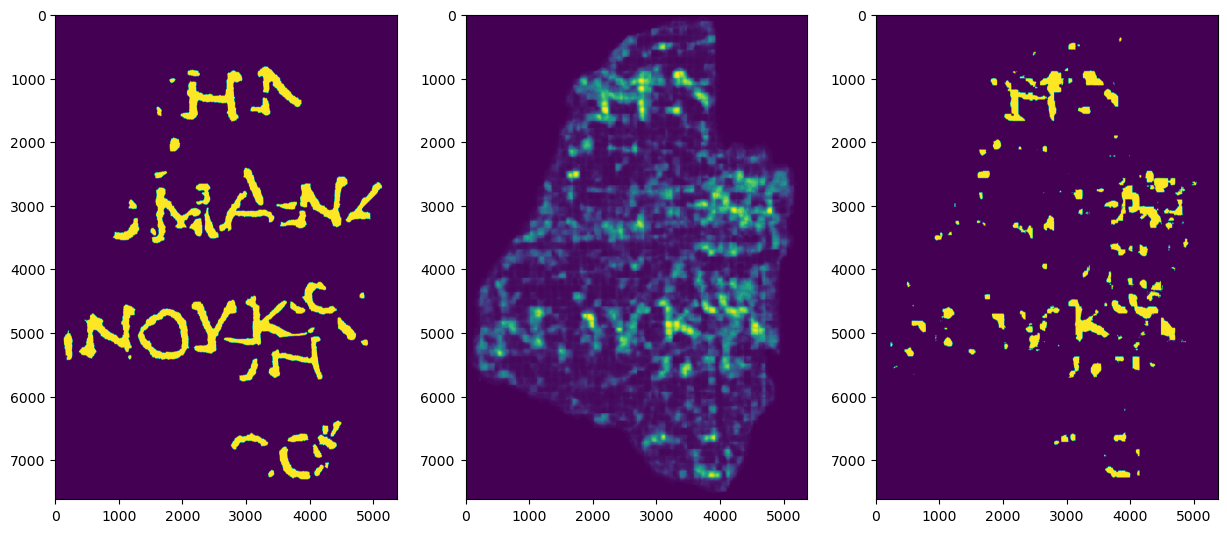

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([24370635.,  5797927.,  2540350.,  1700749.,  1272381.,   995362.,
          829348.,   704827.,   556714.,   458406.,   395955.,   313459.,
          245623.,   209936.,   166916.,   128296.,   100172.,    68653.,
           46516.,    41391.]),
 array([1.12206130e-05, 4.99719568e-02, 9.99326930e-02, 1.49893429e-01,
        1.99854165e-01, 2.49814902e-01, 2.99775638e-01, 3.49736374e-01,
        3.99697110e-01, 4.49657846e-01, 4.99618582e-01, 5.49579319e-01,
        5.99540055e-01, 6.49500791e-01, 6.99461527e-01, 7.49422263e-01,
        7.99383000e-01, 8.49343736e-01, 8.99304472e-01, 9.49265208e-01,
        9.99225944e-01]),
 <BarContainer object of 20 artists>)

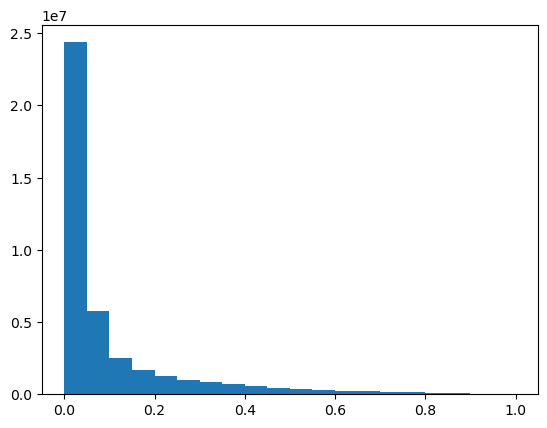

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000